In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
w, h = (224, 224)
base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(w, h, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

2022-09-16 09:22:59.411137: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-16 09:22:59.411198: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ankan): /proc/driver/nvidia/version does not exist
2022-09-16 09:22:59.411875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#Freeze the base model
base_model.trainable = False

2022-09-16 09:23:01.249056: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 102760448 exceeds 10% of free system memory.
2022-09-16 09:23:01.326470: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 102760448 exceeds 10% of free system memory.
2022-09-16 09:23:01.347949: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 102760448 exceeds 10% of free system memory.


In [5]:
from keras.preprocessing.image import ImageDataGenerator

In [6]:
BATCH_SIZE = 10

train_generator = ImageDataGenerator()

val_generator = ImageDataGenerator()

test_generator = ImageDataGenerator()

In [9]:
parent_folder = 'all3_data_quality/Mixed'
train_data_dir = f'{parent_folder}/Train'
test_data_dir = f'{parent_folder}/Test'
val_data_dir = f'{parent_folder}/Validation'

In [10]:
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(w, h),
                                               class_mode='categorical',
#                                                classes=class_subset,
#                                                subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = val_generator.flow_from_directory(val_data_dir,
                                               target_size=(w, h),
                                               class_mode='categorical',
#                                                classes=class_subset,
#                                                subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(w, h),
                                             class_mode='categorical',
#                                              classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 8398 images belonging to 6 classes.
Found 933 images belonging to 6 classes.
Found 2333 images belonging to 6 classes.


In [ ]:
inputs = keras.Input(shape=(w, h, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
outputs = keras.layers.Dense(len(traingen.class_indices), activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [11]:
save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='all3_data_quality_model/tl-vgg16-rms-prop-model_{epoch:02d}.h5')

save_weight = tf.keras.callbacks.ModelCheckpoint(
    filepath='all3_data_quality_model/tl-vgg16-rms-prop-weight_{epoch:02d}.h5',
    save_weights_only=True)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

# rmsprop = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=lr_schedule),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()])
history = model.fit(traingen, epochs=20, validation_data= validgen,
             callbacks=[save_model, save_weight])

Epoch 1/20


2022-09-16 09:23:21.026389: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 102760448 exceeds 10% of free system memory.
2022-09-16 09:23:21.464724: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 102760448 exceeds 10% of free system memory.


840/840 [==============================] - 2596s 3s/step - loss: 57.8183 - categorical_accuracy: 0.9256 - val_loss: 10.6803 - val_categorical_accuracy: 0.9743
Epoch 2/20
840/840 [==============================] - 2685s 3s/step - loss: 9.7309 - categorical_accuracy: 0.9770 - val_loss: 12.6470 - val_categorical_accuracy: 0.9775
Epoch 3/20
840/840 [==============================] - 2707s 3s/step - loss: 5.4789 - categorical_accuracy: 0.9895 - val_loss: 11.6421 - val_categorical_accuracy: 0.9839
Epoch 4/20
840/840 [==============================] - 2733s 3s/step - loss: 2.8280 - categorical_accuracy: 0.9939 - val_loss: 6.7910 - val_categorical_accuracy: 0.9925
Epoch 5/20
840/840 [==============================] - 2741s 3s/step - loss: 3.3931 - categorical_accuracy: 0.9938 - val_loss: 3.2115 - val_categorical_accuracy: 0.9936
Epoch 6/20
840/840 [==============================] - 2729s 3s/step - loss: 1.3692 - categorical_accuracy: 0.9980 - val_loss: 2.2756 - val_categorical_accuracy: 0.9957

In [12]:

# list all data in history
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


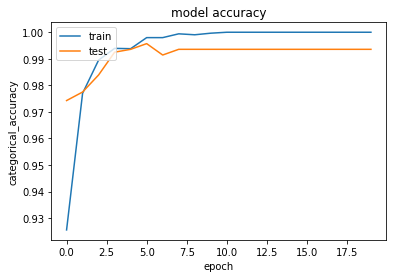

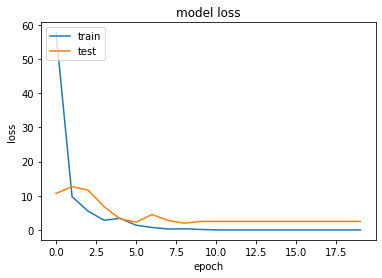

In [13]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()